## Theme: Air Pollution in China

## Title: Effectiveness of "Air Pollution Prevention and Control Action Plan": Comparison between key regions and other regions

### Introduction:
Because of the severse air pollution in the beginning of 2013, China implemented the "Air Pollution Prevention and Control Action Plan" (APPCAP) in sept 2013 in all China with the main focus on 3 key regions: Beijing-Tianjin-Hebei, Yangtze River delta and Pearl River delta. 

In this thesis we want to use the Diff-in-Diffs model to verify if the more intense policy in the 3 key regions help to get better result than the others regions in China. Our hypothese is:

**Ho:** "The more intense policies implemented of key regions are more effective in reducing the air pollution than the less intense policies of others regions"

### Data:
We use the data of 3 pollutant gases (PM10, SO2, NOx) of 30 cities in China, 8 cities in key regions and 22 cities in other regions from 2008 to 2017 to make the comparison.

### Call library

In [1]:
library(tidyverse)
library(lfe)
library(magrittr)
library(lmtest)
library(plm)
library(stargazer)
library(xtable)
library(data.table)
library(clusterSEs)

Warning message:
"package 'tidyverse' was built under R version 3.6.2"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'lfe' was built under R version 3.6.3"Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract

Loading required package: zoo

Attachi

### Import Data:
- import with correct type
- covert character to factor
- choose level of reference

In [2]:
url <- paste("https://raw.githubusercontent.com/KubiaPXH/Memoire-M1/",
             "master/data/final_air_pollution_30cities.csv",  sep="")

df_sd <- read.csv(url)

df <- read_csv(url, col_types = cols(
  city = col_character(),
  year = col_character(),
  PM10 = col_double(),
  SO2 = col_double(),
  NOx = col_double(),
  pop_density = col_double(),
  GRP_pc = col_double(),
  total_gas_supply = col_double(),
  green_coveraged = col_double(),
  post = col_character(),
  key_regions = col_character())
) %>% 
  mutate_if(is.character,as.factor) %>%
  mutate(
    post = relevel(post, ref = '0'),
    key_regions = relevel(key_regions, ref = '0'),
    city = relevel(city, ref = 'Kunming'),
    year = relevel(year, ref = '2013')
  )

year <- c(2008,2009,2010,2011,2012,2013,2014,2015,2016,2017)

str(df)

Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	300 obs. of  11 variables:
 $ city            : Factor w/ 30 levels "Kunming","Beijing",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ year            : Factor w/ 10 levels "2013","2008",..: 2 3 4 5 6 1 7 8 9 10 ...
 $ PM10            : num  123 121 121 113 109 108 116 102 92 84 ...
 $ SO2             : num  36 34 32 28 29 26 22 14 10 8 ...
 $ NOx             : num  49 53 57 56 52 56 57 50 48 46 ...
 $ pop_density     : num  792 759 766 779 791 ...
 $ GRP_pc          : num  63029 70452 75943 81658 87475 ...
 $ total_gas_supply: num  601381 682839 719740 729608 924763 ...
 $ green_coveraged : num  37.1 47.7 55.1 51.6 51.9 ...
 $ post            : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 2 2 2 2 ...
 $ key_regions     : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


### Draw graph of air pollution

- **Graph of PM10**

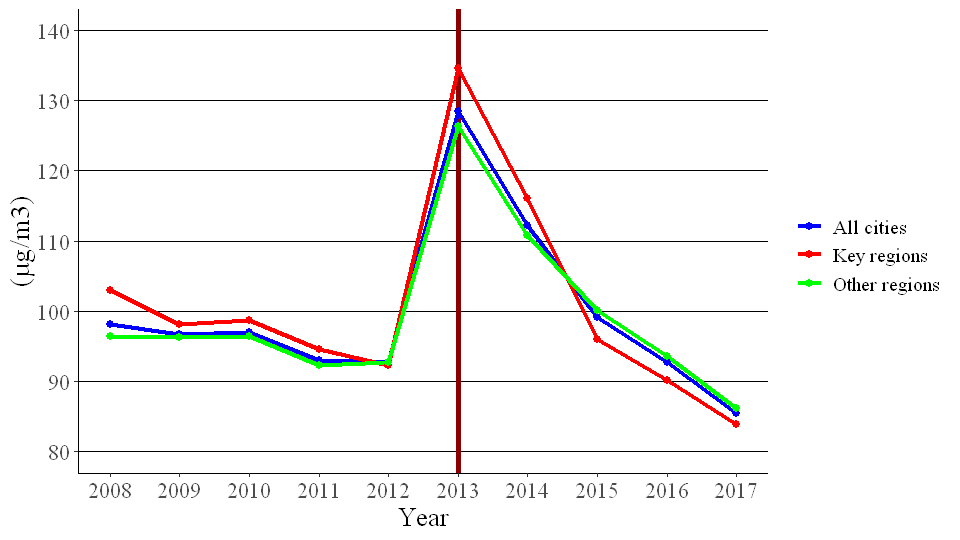

In [3]:
mean_PM10_all <- NULL
for (i in year) {
  subset_year <- subset(df, year == i)
  mean_PM10_all <- c(mean_PM10_all,mean(subset_year$PM10))
}
mean_PM10_key <- NULL
for (i in year) {
  subset_year <- subset(df, year == i & key_regions == 1)
  mean_PM10_key <- c(mean_PM10_key,mean(subset_year$PM10))
}
mean_PM10_nokey <- NULL
for (i in year) {
  subset_year <- subset(df, year == i & key_regions == 0)
  mean_PM10_nokey <- c(mean_PM10_nokey,mean(subset_year$PM10))
}
mean_PM10 <- data.frame(year,mean_PM10_all,mean_PM10_key,mean_PM10_nokey)
# set width and height of the plot
options(repr.plot.width=8, repr.plot.height=4.5)
colors <- c("All cities" = "blue", "Key regions" = "red", "Other regions" = "green")
p1 <- ggplot(data = mean_PM10, aes(x = year)) +
  # draw line showing the begining of policy
  geom_vline(xintercept = 2013, color = "darkred", size = 1.5) +
  # draw line
  geom_line(aes(y = mean_PM10_all, color = "All cities"), size = 1.2) +
  geom_line(aes(y = mean_PM10_key, color = "Key regions"), size = 1.2) +
  geom_line(aes(y = mean_PM10_nokey, color = "Other regions"), size = 1.2) +
  # draw year point 
  geom_point(aes(x = year, y = mean_PM10_all, color = "All cities"), size = 2) +
  geom_point(aes(x = year, y = mean_PM10_key, color = "Key regions"), size = 2) +
  geom_point(aes(x = year, y = mean_PM10_nokey, color = "Other regions"), size = 2) +
  # scale and breaks
  scale_x_continuous(breaks = seq(2008,2017,1)) +
  scale_y_continuous(breaks = seq(80,140,10), limits = c(80,140)) +
   # modify xlab, y lab, legend
  scale_color_manual(values = colors) +
  labs(x = "Year",
       y = "(µg/m3)",
       color = "") +
  theme(axis.title = element_text(size = 16, family = "serif"),
        axis.text = element_text(size = 13, family = "serif"),
        axis.line = element_line(color = "black"),
        legend.text = element_text(size = 12, family = "serif"),
        legend.key = element_blank(),
        panel.grid.major.y = element_line(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.background = element_blank())
print(p1)

- **Graph of SO2**

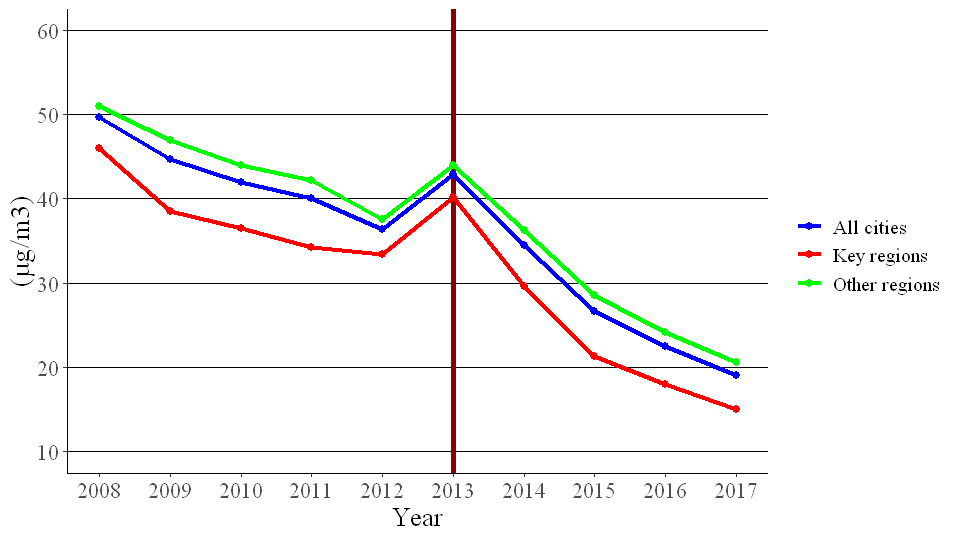

In [4]:
mean_SO2_all <- NULL
for (i in year) {
  subset_year <- subset(df, year == i)
  mean_SO2_all <- c(mean_SO2_all,mean(subset_year$SO2))
}
mean_SO2_key <- NULL
for (i in year) {
  subset_year <- subset(df, year == i & key_regions == 1)
  mean_SO2_key <- c(mean_SO2_key,mean(subset_year$SO2))
}
mean_SO2_nokey <- NULL
for (i in year) {
  subset_year <- subset(df, year == i & key_regions == 0)
  mean_SO2_nokey <- c(mean_SO2_nokey,mean(subset_year$SO2))
}
mean_SO2 <- data.frame(year,mean_SO2_all,mean_SO2_key,mean_SO2_nokey)
# set width and height of the plot
options(repr.plot.width=8, repr.plot.height=4.5)
colors <- c("All cities" = "blue", "Key regions" = "red", "Other regions" = "green")
p2 <- ggplot(data = mean_SO2, aes(x = year)) +
  # draw line showing the begining of policy
  geom_vline(xintercept = 2013, color = "darkred", size = 1.5) +
  # draw line
  geom_line(aes(y = mean_SO2_all, color = "All cities"), size = 1.2) +
  geom_line(aes(y = mean_SO2_key, color = "Key regions"), size = 1.2) +
  geom_line(aes(y = mean_SO2_nokey, color = "Other regions"), size = 1.2) +
  # draw year point 
  geom_point(aes(x = year, y = mean_SO2_all, color = "All cities"), size = 2) +
  geom_point(aes(x = year, y = mean_SO2_key, color = "Key regions"), size = 2) +
  geom_point(aes(x = year, y = mean_SO2_nokey, color = "Other regions"), size = 2) +
  # scale and breaks
  scale_x_continuous(breaks = seq(2008,2017,1)) +
  scale_y_continuous(breaks = seq(10,60,10), limits = c(10,60)) +
  # modify xlab, y lab, legend
  scale_color_manual(values = colors) +
  labs(x = "Year",
       y = "(µg/m3)",
       color = "") +
  theme(axis.title = element_text(size = 16, family = "serif"),
        axis.text = element_text(size = 13, family = "serif"),
        axis.line = element_line(color = "black"),
        legend.text = element_text(size = 12, family = "serif"),
        legend.key = element_blank(),
        panel.grid.major.y = element_line(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.background = element_blank()) 
print(p2)

- **Graph of NOx**

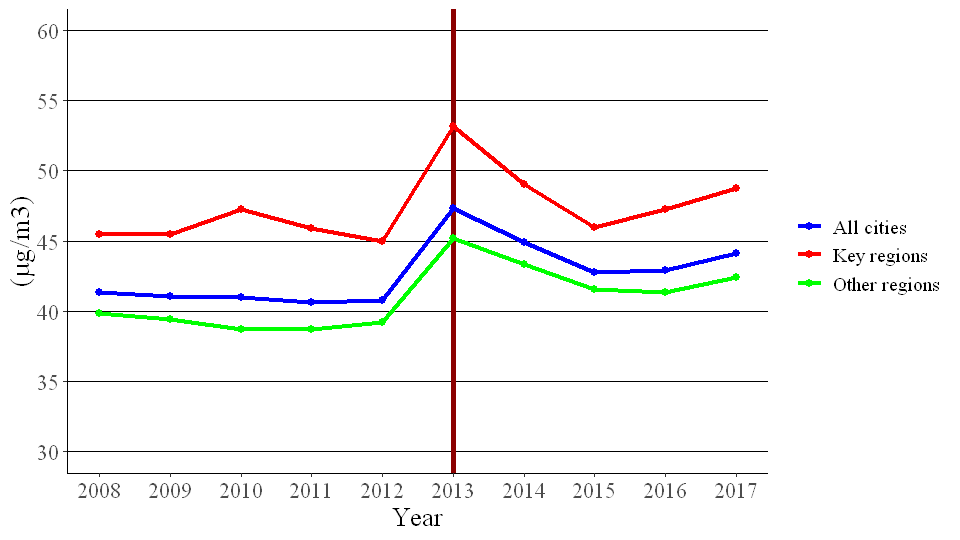

In [5]:
mean_NOx_all <- NULL
for (i in year) {
  subset_year <- subset(df, year == i)
  mean_NOx_all <- c(mean_NOx_all,mean(subset_year$NOx))
}
mean_NOx_key <- NULL
for (i in year) {
  subset_year <- subset(df, year == i & key_regions == 1)
  mean_NOx_key <- c(mean_NOx_key,mean(subset_year$NOx))
}
mean_NOx_nokey <- NULL
for (i in year) {
  subset_year <- subset(df, year == i & key_regions == 0)
  mean_NOx_nokey <- c(mean_NOx_nokey,mean(subset_year$NOx))
}
mean_NOx <- data.frame(year,mean_NOx_all,mean_NOx_key,mean_NOx_nokey)
# set width and height of the plot
options(repr.plot.width=8, repr.plot.height=4.5)
colors <- c("All cities" = "blue", "Key regions" = "red", "Other regions" = "green")
p3 <- ggplot(data = mean_NOx, aes(x = year)) +
  # draw line showing the begining of policy
  geom_vline(xintercept = 2013, color = "darkred", size = 1.5) +
  # draw line
  geom_line(aes(y = mean_NOx_all, color = "All cities"), size = 1.2) +
  geom_line(aes(y = mean_NOx_key, color = "Key regions"), size = 1.2) +
  geom_line(aes(y = mean_NOx_nokey, color = "Other regions"), size = 1.2) +
  # draw year point 
  geom_point(aes(x = year, y = mean_NOx_all, color = "All cities"), size = 2) +
  geom_point(aes(x = year, y = mean_NOx_key, color = "Key regions"), size = 2) +
  geom_point(aes(x = year, y = mean_NOx_nokey, color = "Other regions"), size = 2) +
  # scale and breaks
  scale_x_continuous(breaks = seq(2008,2017,1)) +
  scale_y_continuous(breaks = seq(30,60,5), limits = c(30,60)) +
  # modify xlab, y lab, legend
  scale_color_manual(values = colors) +
  labs(x = "Year",
       y = "(µg/m3)",
       color = "") +
  theme(axis.title = element_text(size = 16, family = "serif"),
        axis.text = element_text(size = 13, family = "serif"),
        axis.line = element_line(color = "black"),
        legend.text = element_text(size = 12, family = "serif"),
        legend.key = element_blank(),
        panel.grid.major.y = element_line(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.background = element_blank()) 
print(p3)

### Push post forward

Normally, **post** (dummy variable for year) begin to be 1 in 2013. But as we see in the graphs, the policy was began to implement on 10th sept 2013 (the dark red vertical line) which means that it hardly had an effect on the level of air pollution in 2013. Therefore, we move post forward one year (**post** = 1 begin in 2014) as the policy is likely to take result from 2014.

In [6]:
for (i in 1:nrow(df)) {
  if (df$year[i] == 2013) {
    df$post[i] <- 0
  }
}
for (i in 1:nrow(df_sd)) {
  if (df$year[i] == 2013) {
    df$post[i] <- 0
  }
}

### Statistics decriptive table

In [7]:
stargazer(df_sd, type = "text", 
          title = "Summary statistics of the variables", 
          digits = 2,
          omit = c("year","post","key_regions"),
          omit.summary.stat = c("p25","p75"))


Summary statistics of the variables
Statistic         N     Mean     St. Dev.   Min      Max   
-----------------------------------------------------------
PM10             300   99.55      31.88      34      305   
SO2              300   35.85      19.54      5       105   
NOx              300   42.67      11.00      12      68    
pop_density      300   635.20     419.31   130.23 2,294.59 
GRP_pc           300 67,856.42  30,150.49  18,025  185,338 
total_gas_supply 300 164,394.50 286,955.50 1,966  1,976,114
green_coveraged  300   40.09       5.73    24.20    70.30  
-----------------------------------------------------------


### The differences between the result in key regions and no key regions

As we formed our hypothese:

**Ho:** "The more intense policies implemented of key regions are more effective in reducing the air pollution than the less intense policies of others regions"

We should see a bigger reduction in air pollution in key regions than in no key regions. This part calculate those differences.

In [8]:
# Create subset of year and key regions
df_key_2017 <- subset(df, key_regions == 1 & year == 2017)
df_key_2013 <- subset(df, key_regions == 1 & year == 2013)
df_nokey_2017 <- subset(df, key_regions == 0 & year == 2017)
df_nokey_2013 <- subset(df, key_regions == 0 & year == 2013)

# PM10: Ok
key_PM10_2017 <- mean(df_key_2017$PM10)
key_PM10_2013 <- mean(df_key_2013$PM10)
nokey_PM10_2017 <- mean(df_nokey_2017$PM10)
nokey_PM10_2013 <- mean(df_nokey_2013$PM10)
diff_PM10_key <- (key_PM10_2013 - key_PM10_2017)
diff_PM10_nokey <- (nokey_PM10_2013 - nokey_PM10_2017)
did_PM10 <- (diff_PM10_key - diff_PM10_nokey)

#SO2: Ok
key_SO2_2017 <- mean(df_key_2017$SO2)
key_SO2_2013 <- mean(df_key_2013$SO2)
nokey_SO2_2017 <- mean(df_nokey_2017$SO2)
nokey_SO2_2013 <- mean(df_nokey_2013$SO2)
diff_SO2_key <- (key_SO2_2013 - key_SO2_2017)
diff_SO2_nokey <- (nokey_SO2_2013 - nokey_SO2_2017)
did_SO2 <- (diff_SO2_key - diff_SO2_nokey)

#NOx: Ok
key_NOx_2017 <- mean(df_key_2017$NOx)
key_NOx_2013 <- mean(df_key_2013$NOx)
nokey_NOx_2017 <- mean(df_nokey_2017$NOx)
nokey_NOx_2013 <- mean(df_nokey_2013$NOx)
diff_NOx_key <- (key_NOx_2013 - key_NOx_2017)
diff_NOx_nokey <- (nokey_NOx_2013 - nokey_NOx_2017)
did_NOx <- (diff_NOx_key - diff_NOx_nokey)

# Means table for DiD
diff_matrix <- matrix(c(diff_PM10_key,diff_SO2_key,diff_NOx_key,
                        diff_PM10_nokey,diff_SO2_nokey,diff_NOx_nokey,
                        did_PM10,did_SO2,did_NOx),
                      ncol = 3,
                      byrow = TRUE,
                      dimnames = list(c("Key regions","No key regions","Difference"),
                                      c("PM10","SO2","NOx")))
print("Average Reduction of Pollutant Gas")
xtable(diff_matrix, 
       caption = "Average Reduction of Pollutant Gas",
       digits = 2)

[1] "Average Reduction of Pollutant Gas"


,PM10,SO2,NOx
Key regions,50.75000,25.125000,4.375000
No key regions,40.13636,23.318182,2.772727
Difference,10.61364,1.806818,1.602273


**Confirmed** that the reductions in key regions are bigger than no key regions

### Model Diff in Diff 

As we want to test the hypothese **Ho**, we use the model diff in diff to test if the effectiveness of the policy in key regions is significantly different from the effectiveness of the policy in no key regions:

$$\text { ln } \mathrm{Y}_{c t}=\beta_{1} \text{ Post}_{t}+\beta_{2} \text{ Key regions}_{c}+\beta_{3} \text{ Post}_{t} \times \text{ Key regions}_{c}+X_{c t}+\gamma_{c}+\gamma_{t}+\epsilon_{c t}$$

${Y}_{c t}$ is the level of concentration of each pollutant gas

#### Model PM10

- **DiD with city and year fixed effect**

In [9]:
model_did_PM10_all <- plm(log(PM10) ~ post + key_regions + post*key_regions +
                            log(pop_density) + log(GRP_pc) + log(total_gas_supply) + green_coveraged,
                          data = df,
                          index = c("city","year"),
                          model = "within",
                          effect = "twoways"
)
summary(model_did_PM10_all)

Twoways effects Within Model

Call:
plm(formula = log(PM10) ~ post + key_regions + post * key_regions + 
    log(pop_density) + log(GRP_pc) + log(total_gas_supply) + 
    green_coveraged, data = df, effect = "twoways", model = "within", 
    index = c("city", "year"))

Balanced Panel: n = 30, T = 10, N = 300

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.3291661 -0.0709019  0.0071825  0.0771800  0.5159116 

Coefficients:
                        Estimate Std. Error t-value  Pr(>|t|)    
log(pop_density)       0.4038622  0.1764633  2.2886 0.0229150 *  
log(GRP_pc)           -0.2750976  0.0776398 -3.5433 0.0004696 ***
log(total_gas_supply)  0.0162029  0.0174913  0.9263 0.3551411    
green_coveraged        0.0010308  0.0018069  0.5705 0.5688587    
post1:key_regions1    -0.1031311  0.0354910 -2.9058 0.0039832 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    4.4145
Residual Sum of Squares: 4.0781
R-Squared:      0.07619

- **Bootstraping and Clustering**

In [10]:
coef_bsed_clustered_PM10 <- cluster.bs.plm(mod = model_did_PM10_all, dat = df, cluster = "group",
               ci.level = 0.95, boot.reps = 1000, cluster.se = TRUE,
               report = TRUE, prog.bar = TRUE)

  |======================================================================| 100%

 Cluster Bootstrap p-values:  
 
            variable name   cluster bootstrap p-value
         log(pop_density)                       0.187
              log(GRP_pc)                       0.022
    log(total_gas_supply)                       0.541
          green_coveraged                       0.565
       post1:key_regions1                       0.098

 Confidence Intervals (derived from bootstrapped t-statistics):  
 
        variable name                CI lower               CI higher
     log(pop_density)      -0.201862276901178        1.00958669640514
          log(GRP_pc)      -0.499842228160726     -0.0503529476399959
log(total_gas_supply)     -0.0473297278880797      0.0797355868085538
      green_coveraged      -0.002542103772198     0.00460361802247909
   post1:key_regions1      -0.225518108209712      0.0192558855727767


****Note: 1 variables were unidentified in the model and are not report

- **Using felm (to get full R2)**

In [14]:
model_did_PM10_all_fle <- felm(formula=log(PM10) ~ post *  key_regions + 
                             log(pop_density) + log(GRP_pc) + log(total_gas_supply) + green_coveraged|
                             city + year| 0 |FALSE, data = df, exactDOF=TRUE)
summary(model_did_PM10_all_fle)$r2

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"

[1] 0.8685294

#### Model SO2

- **DiD with city and year fixed effects**

In [15]:
model_did_SO2_all <- plm(log(SO2) ~ post + key_regions + post*key_regions +
                            log(pop_density) + log(GRP_pc) + log(total_gas_supply) + green_coveraged,
                          data = df,
                          index = c("city","year"),
                          model = "within",
                          effect = "twoways"
)
summary(model_did_SO2_all)

Twoways effects Within Model

Call:
plm(formula = log(SO2) ~ post + key_regions + post * key_regions + 
    log(pop_density) + log(GRP_pc) + log(total_gas_supply) + 
    green_coveraged, data = df, effect = "twoways", model = "within", 
    index = c("city", "year"))

Balanced Panel: n = 30, T = 10, N = 300

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.6925883 -0.1612468 -0.0051443  0.1677157  0.6128060 

Coefficients:
                        Estimate Std. Error t-value Pr(>|t|)   
log(pop_density)       0.0578192  0.3596398  0.1608 0.872402   
log(GRP_pc)           -0.4850833  0.1582333 -3.0656 0.002405 **
log(total_gas_supply)  0.0141892  0.0356480  0.3980 0.690935   
green_coveraged        0.0010290  0.0036824  0.2794 0.780141   
post1:key_regions1    -0.1508786  0.0723322 -2.0859 0.037977 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    17.674
Residual Sum of Squares: 16.939
R-Squared:      0.041598
Adj. R-Squa

- **Bootstraping and Clustering**

In [16]:
coef_bsed_clustered_SO2 <- cluster.bs.plm(mod = model_did_SO2_all, dat = df, cluster = "group",
                                           ci.level = 0.95, boot.reps = 1000, cluster.se = TRUE,
                                           report = TRUE, prog.bar = TRUE)

  |======================================================================| 100%

 Cluster Bootstrap p-values:  
 
            variable name   cluster bootstrap p-value
         log(pop_density)                       0.938
              log(GRP_pc)                       0.055
    log(total_gas_supply)                       0.761
          green_coveraged                       0.806
       post1:key_regions1                       0.308

 Confidence Intervals (derived from bootstrapped t-statistics):  
 
        variable name                CI lower               CI higher
     log(pop_density)       -1.61759213884349        1.73323044519959
          log(GRP_pc)      -0.987825158442299      0.0176585622472101
log(total_gas_supply)      -0.116109941800872       0.144488412028761
      green_coveraged    -0.00691363803914518     0.00897159840976783
   post1:key_regions1      -0.433723591912684       0.131966392013067


****Note: 1 variables were unidentified in the model and are not report

- **Using felm (to get full R2)**

In [17]:
model_did_SO2_all_fle <- felm(formula=log(SO2) ~ post *  key_regions + 
                                 log(pop_density) + log(GRP_pc) + log(total_gas_supply) + green_coveraged|
                                 city + year| 0 |FALSE, data = df, exactDOF=TRUE)
summary(model_did_SO2_all_fle)$r2

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"

[1] 0.8600448

#### Model NOx

- **DiD with city and year fixed effects**

In [18]:
model_did_NOx_all <- plm(log(NOx) ~ post + key_regions + post*key_regions +
                           log(pop_density) + log(GRP_pc) + log(total_gas_supply) + green_coveraged,
                         data = df,
                         index = c("city","year"),
                         model = "within",
                         effect = "twoways"
)
summary(model_did_NOx_all)

Twoways effects Within Model

Call:
plm(formula = log(NOx) ~ post + key_regions + post * key_regions + 
    log(pop_density) + log(GRP_pc) + log(total_gas_supply) + 
    green_coveraged, data = df, effect = "twoways", model = "within", 
    index = c("city", "year"))

Balanced Panel: n = 30, T = 10, N = 300

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.5226998 -0.0782206 -0.0068066  0.0842335  0.5285372 

Coefficients:
                        Estimate Std. Error t-value Pr(>|t|)
log(pop_density)      -0.0759781  0.2152013 -0.3531   0.7243
log(GRP_pc)           -0.1230571  0.0946837 -1.2997   0.1949
log(total_gas_supply)  0.0089577  0.0213311  0.4199   0.6749
green_coveraged        0.0032834  0.0022035  1.4901   0.1374
post1:key_regions1    -0.0449047  0.0432821 -1.0375   0.3005

Total Sum of Squares:    6.1765
Residual Sum of Squares: 6.0651
R-Squared:      0.018029
Adj. R-Squared: -0.14691
F-statistic: 0.940012 on 5 and 256 DF, p-value: 0.45557

- **Bootstraping and Clustering**

In [19]:
coef_bsed_clustered_NOx <- cluster.bs.plm(mod = model_did_NOx_all, dat = df, cluster = "group",
                                          ci.level = 0.95, boot.reps = 1000, cluster.se = TRUE,
                                          report = TRUE, prog.bar = TRUE)

  |======================================================================| 100%

 Cluster Bootstrap p-values:  
 
            variable name   cluster bootstrap p-value
         log(pop_density)                       0.812
              log(GRP_pc)                       0.467
    log(total_gas_supply)                       0.741
          green_coveraged                       0.053
       post1:key_regions1                       0.633

 Confidence Intervals (derived from bootstrapped t-statistics):  
 
        variable name                CI lower               CI higher
     log(pop_density)      -0.912080946464786       0.760124691895795
          log(GRP_pc)       -0.47931082058831       0.233196562843006
log(total_gas_supply)     -0.0760353567651033       0.093950671824459
      green_coveraged   -1.88983098329764e-05     0.00658573586316118
   post1:key_regions1      -0.226281685807868       0.136472343111427


****Note: 1 variables were unidentified in the model and are not report

- **Using felm (to get full R2)**

In [20]:
model_did_NOx_all_fle <- felm(formula=log(NOx) ~ post *  key_regions + 
                                 log(pop_density) + log(GRP_pc) + log(total_gas_supply) + green_coveraged|
                                 city + year| 0 |FALSE, data = df, exactDOF=TRUE)
summary(model_did_NOx_all_fle)$r2

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"

[1] 0.7770397

### Table for regression

#### No bootstrapped and clustered

In [21]:
stargazer(model_did_PM10_all, model_did_SO2_all, model_did_NOx_all, 
          title = "Difference-in-Differences model with city and year fixed effects",
          type = "text",
          align = TRUE,
          # set covariate variable name
          covariate.labels = c("post*key\\_regions","log(pop\\_density)",
                               "log(GRP\\_pc)","log(gas\\_supply)","green\\_coveraged"),
          # set covariate variable order
          order = c(5,1,2,3,4),
          omit.stat = c("adj.rsq"))


Difference-in-Differences model with city and year fixed effects
                               Dependent variable:     
                          -----------------------------
                          log(PM10)  log(SO2)  log(NOx)
                             (1)        (2)      (3)   
-------------------------------------------------------
post*key_regions          -0.103***  -0.151**   -0.045 
                           (0.035)    (0.072)  (0.043) 
                                                       
log(pop_density)           0.404**     0.058    -0.076 
                           (0.176)    (0.360)  (0.215) 
                                                       
log(GRP_pc)               -0.275***  -0.485***  -0.123 
                           (0.078)    (0.158)  (0.095) 
                                                       
log(gas_supply)             0.016      0.014    0.009  
                           (0.017)    (0.036)  (0.021) 
                                      

#### Bootstrapped and clustered

In [22]:
stargazer(model_did_PM10_all, model_did_SO2_all, model_did_NOx_all, 
          title = "Difference-in-Differences model with city and year fixed effects",
          type = "text",
          align = TRUE,
          p = list(coef_bsed_clustered_PM10$p.values,
                   coef_bsed_clustered_SO2$p.values,
                   coef_bsed_clustered_NOx$p.values),
          # set covariate variable name
          covariate.labels = c("post*key\\_regions","log(pop\\_density)",
                               "log(GRP\\_pc)","log(gas\\_supply)","green\\_coveraged"),
          # set covariate variable order
          order = c(5,1,2,3,4),
          omit.stat = c("adj.rsq"))


Difference-in-Differences model with city and year fixed effects
                               Dependent variable:     
                          -----------------------------
                          log(PM10)  log(SO2)  log(NOx)
                             (1)        (2)      (3)   
-------------------------------------------------------
post*key_regions           -0.103*    -0.151    -0.045 
                           (0.035)    (0.072)  (0.043) 
                                                       
log(pop_density)            0.404      0.058    -0.076 
                           (0.176)    (0.360)  (0.215) 
                                                       
log(GRP_pc)                -0.275**   -0.485*   -0.123 
                           (0.078)    (0.158)  (0.095) 
                                                       
log(gas_supply)             0.016      0.014    0.009  
                           (0.017)    (0.036)  (0.021) 
                                      

Here we see that for PM10, the **post x key regions** is significant (p<0.1) and negative
=> **Ho** est accepted for PM10

### Robustness test: Parallel trend assumption

We test the parallel trend assumption using model:

$$\text { ln } \mathrm{Y}_{c t}=\sum_{t=2008}^{2017} \beta_{t} \text{ Key regions}_{c} { * } \gamma_{t}+X_{c t}+\delta_{c}+\gamma_{t}+\varepsilon_{c t}$$

**note:** for the theory of parallel trend assumption check the [article](https://drive.google.com/file/d/1sGOhZEliCDLpszyuVlgXfM4Xu_KCB5Q9/view?usp=sharing) of Pischke

In [23]:
robust_PM10 <- plm(log(PM10) ~ year + key_regions + year*key_regions +
                     log(pop_density) + log(GRP_pc) + log(total_gas_supply) + green_coveraged,
                      data = df,
                      index = c("city","year"),
                      model = "within",
                      effect = "twoways"
)
summary(robust_PM10)

key_year <- c("key_2008","key_2009","key_2010","key_2011","key_2012","key_2013","key_2014","key_2015","key_2016","key_2017")

Twoways effects Within Model

Call:
plm(formula = log(PM10) ~ year + key_regions + year * key_regions + 
    log(pop_density) + log(GRP_pc) + log(total_gas_supply) + 
    green_coveraged, data = df, effect = "twoways", model = "within", 
    index = c("city", "year"))

Balanced Panel: n = 30, T = 10, N = 300

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.3250799 -0.0711671  0.0035788  0.0773349  0.5094337 

Coefficients:
                        Estimate Std. Error t-value Pr(>|t|)    
log(pop_density)       0.3923290  0.1797772  2.1823 0.030026 *  
log(GRP_pc)           -0.3037091  0.0812912 -3.7361 0.000232 ***
log(total_gas_supply)  0.0160145  0.0177765  0.9009 0.368527    
green_coveraged        0.0012692  0.0018497  0.6861 0.493260    
year2008:key_regions1  0.0596624  0.0755492  0.7897 0.430449    
year2009:key_regions1  0.0147695  0.0748172  0.1974 0.843670    
year2010:key_regions1 -0.0093199  0.0749874 -0.1243 0.901189    
year2011:key_regions1 -0.023077

- **Graph of Robust test for PM10**: with the 90% confidence interval

Warning message:
"Removed 1 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_errorbar)."

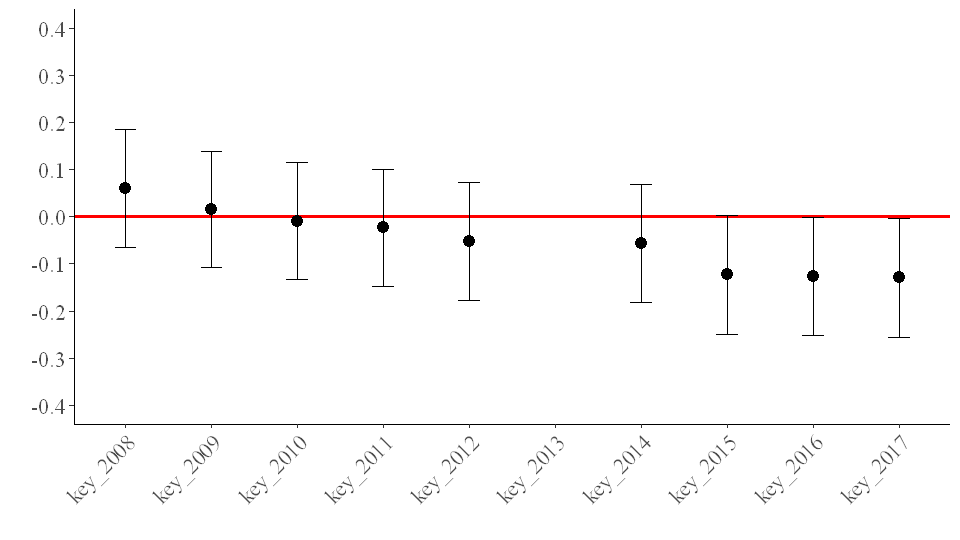

In [24]:
confint_PM10 <- confint(robust_PM10, level = 0.9)
for (i in 1:4){
  confint_PM10 <- confint_PM10[-1,]
}

coef_robust_PM10 <-NULL
for (i in 2008:2016){
  coef_robust_PM10 <- c(coef_robust_PM10,robust_PM10$coefficients[i-2003])
}
coef_robust_PM10 <- data.frame(coef_robust_PM10)

df_robust_PM10 <- data.frame(confint_PM10,coef_robust_PM10)
dt_robust_PM10 <- data.table(df_robust_PM10)
dt_robust_PM10 <- rbindlist(list(dt_robust_PM10[1:5, ], as.list(c(NA,NA,NA)), dt_robust_PM10[6:9, ]))
df_robust_PM10 <- data.frame(key_year,dt_robust_PM10)
colnames(df_robust_PM10) <- c("key_year","x5","x95","coef")

### Draw robust test graph
ggplot(df_robust_PM10, aes(x = key_year, y = coef)) +
  # draw line showing the begining of policy
  geom_hline(yintercept = 0, color = "red", size = 1) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = x5, ymax = x95), width = 0.25) +
  scale_y_continuous(breaks = seq(-0.4,0.4,0.1), limits = c(-0.4,0.4)) +
  labs(x = "",
       y = "") +
  # parameter graph
  theme(axis.text.x = element_text(size = 13, family = "serif", angle = 45, hjust = 1),
        axis.text.y = element_text(size = 13, family = "serif"),
        axis.line = element_line(color = "black"),
        legend.position = "none",
        panel.grid.major.y = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.background = element_blank()) 

Coef is not significant before 2013 and become more and more significant after 2013 => **model is robust**